# Refine Models

In this notebook we will take our best performing baseline models and perform hyperparameter tuning in order to find the best settings for optimal performance.

We will also perform Stratified K-Fold Cross validation on our models in order to accurately predict the models performance.

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Import Scipy Models
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Train/Test Cross Validation

First we will define our features that we chose based on findings in the exploratory analysis.
The features we will use are:
- Age
- Booking Window Days
- Hipertension
- Scholarship
- Diabetes
- Handcap
- SMS Received
- Scheduled House
- Appointment Day of Week
- Percentage of previous no-shows for the patient ("No-show_user_mean")
- Percentage of previous no-shows for the patients neighbourhood ("No-show_neighbourhood_mean")

In [2]:
data = pd.read_csv('../data/clean_data.csv')

_FEATURES = ['Age', 'booking_window_days', 'Hipertension', 'Scholarship', 
             'Diabetes', 'Handcap', 'SMS_received', 'ScheduledHour', 
             'AppointmentDayOfWeek']
_TARGET = 'No-show'


A number of the features can only be generated on the train_test split has taken place because they rely on a patients history. These features are:
- Percentage of previous no-shows for the patient ("No-show_user_mean")
- Percentage of previous no-shows for the patients neighbourhood ("No-show_neighbourhood_mean")
- Total number of previous no-shows for the patient ("No-show_sum")

Therefore we need to create these features within the train/test split method.

**Note:** Below we are using 5-Fold Stratified Cross Validation to evalute the performance of our datasets.

In [3]:
def run_model(data, model):
    skf = StratifiedKFold(n_splits=5)

    X = data[_FEATURES].values 
    y = data[_TARGET].values 

    scores = np.array([])
    cms = np.array([[0, 0], [0, 0]])

    for train_index, test_index in skf.split(X, y):
        # Calculate the user history
        train = data.iloc[train_index]
        train = train.join(train.groupby('PatientId')['No-show'].agg(np.mean), on='PatientId', rsuffix='_user_mean')
        train = train.join(train.groupby('Neighbourhood')['No-show'].agg(np.mean), on='Neighbourhood', rsuffix='_neighbourhood_mean')
        train = train.join(train.groupby('PatientId')['No-show'].agg('sum'), on='PatientId', rsuffix='_sum')
        #train = train.join(train.groupby('PatientId')['Age'].count(), on='PatientId', rsuffix='_count')
        
        test = data.iloc[test_index]
        
        test = pd.merge(test, train[['PatientId', 'No-show_user_mean']], on='PatientId', how='left') 
        test.at[test['No-show_user_mean'].isna(), 'No-show_user_mean'] = 1
        
        test = pd.merge(test, train[['PatientId', 'No-show_neighbourhood_mean']], on='PatientId', how='left') 
        test.at[test['No-show_neighbourhood_mean'].isna(), 'No-show_neighbourhood_mean'] = 1
        
        test = pd.merge(test, train[['PatientId', 'No-show_sum']], on='PatientId', how='left')
        test.at[test['No-show_sum'].isna(), 'No-show_sum'] = 0
        
        #test = pd.merge(test, train[['PatientId', 'Age_count']], on='PatientId', how='left')
        #test.at[test['Age_count'].isna(), 'Age_count'] = 0
        
        X_train = train[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
        y_train = train[_TARGET].values
        
        X_test = test[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
        y_test = test[_TARGET].values
        
        #X_train, X_test = X[train_index], X[test_index]
        #y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        scores = np.append(scores, model.score(X_test, y_test))

        y_pred = model.predict(X_test)
        
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        
        cm = confusion_matrix(y_test, y_pred)
        cms = np.add(cms, cm)
    
    return scores, cms, precision, recall


# Logistic Regression

Here we will be tuning the learning rate parameter.

In [4]:
%%capture

param_grid = {'C': [0.001, 0.01, 0.1]}

lr_results = {}

for C in param_grid['C']:
    model = LogisticRegression(random_state=0, class_weight='balanced', C=C)
    
    scores, cms, precision, recall = run_model(data, model)
    
    lr_results[C] = (scores, cms, precision, recall)

Score: 0.867650
Precision: 0.936455
Recall: 0.955033


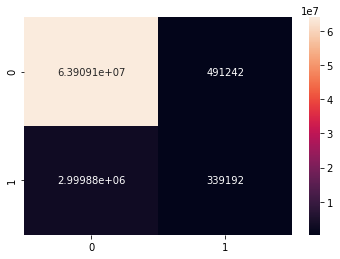

Score: 0.865805
Precision: 0.936828
Recall: 0.954884


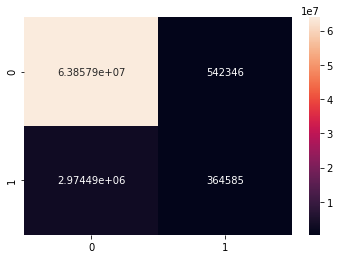

Score: 0.865539
Precision: 0.936284
Recall: 0.954624


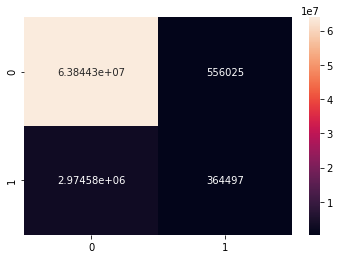

In [5]:
for C in lr_results.keys():
    scores, cms, precision, recall = lr_results[C]
    
    print('Score: %f' % (np.mean(scores)))
    print('Precision: %f' % (np.mean(precision)))
    print('Recall: %f' % (np.mean(recall)))
    
    df_cm = pd.DataFrame(cms, range(2), range(2))
    sns.heatmap(df_cm, annot=True, fmt='g') # font size
    plt.show() 

Here we can see that we have increased the recall and precision of the logistic regression model. We have also found that the optimal value for the `Learning Rate = 0.001`.

# Stochastic Gradient Descent

Here we will run experiments using different loss functions and alpha values in an attempt to optimise our Stochastic Gradient Descent model.

In [10]:
losses = ['hinge', 'modified_huber']
alphas = [0.0001, 0.001, 0.01]

sgd_results = {}

for loss in tqdm(losses):
        for alpha in alphas:
            model = SGDClassifier(loss=loss, penalty="l2", max_iter=5, alpha=alpha, class_weight='balanced')
            
            scores, cms, precision, recall = run_model(data, model)

            sgd_results[(loss, alpha)] = (scores, cms, precision, recall)



  0%|          | 0/2 [00:00<?, ?it/s]/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergenc

hinge 0.0001
Score: 0.676892
Precision: 0.918684
Recall: 0.113297


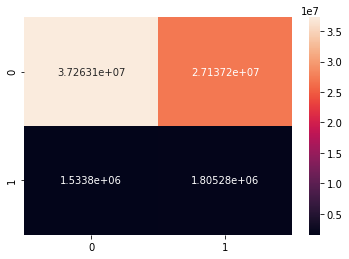

hinge 0.001
Score: 0.669248
Precision: 0.939205
Recall: 0.956315


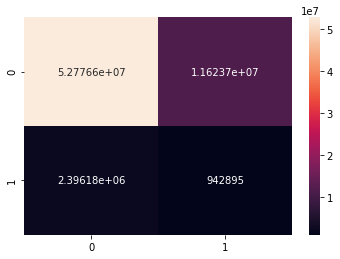

hinge 0.01
Score: 0.862329
Precision: 0.939262
Recall: 0.956304


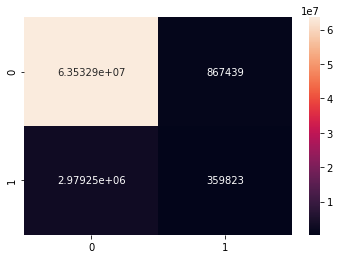

modified_huber 0.0001
Score: 0.841148
Precision: 0.938535
Recall: 0.955806


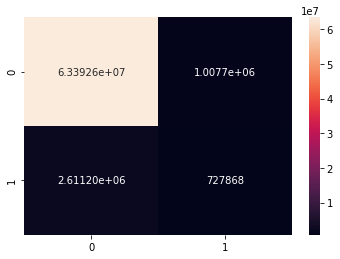

modified_huber 0.001
Score: 0.861432
Precision: 0.938469
Recall: 0.955996


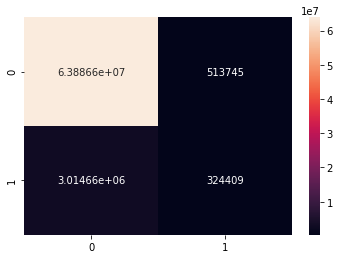

modified_huber 0.01
Score: 0.845890
Precision: 0.934450
Recall: 0.948876


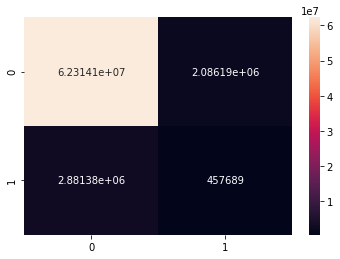

In [11]:
for loss, alpha in sgd_results.keys():
    print(loss, alpha)
    
    scores, cms, precision, recall = sgd_results[(loss, alpha)]
    
    print('Score: %f' % (np.mean(scores)))
    print('Precision: %f' % (np.mean(precision)))
    print('Recall: %f' % (np.mean(recall)))

    df_cm = pd.DataFrame(cms, range(2), range(2))
    sns.heatmap(df_cm, annot=True, fmt='g') # font size
    plt.show() 

Here we can see that though our Stochastic Gradient Descent models get very close to the performance of our logistic regression models, they fail to beat it.

# Results

From our findings above, we can see that our best performing model is the **Logistic Regression Model** with a **learning rate of 0.001**.